In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats



In [2]:
def myround(x, base=5):
    return base * round(x/base)

In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [ ]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)


In [6]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [7]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


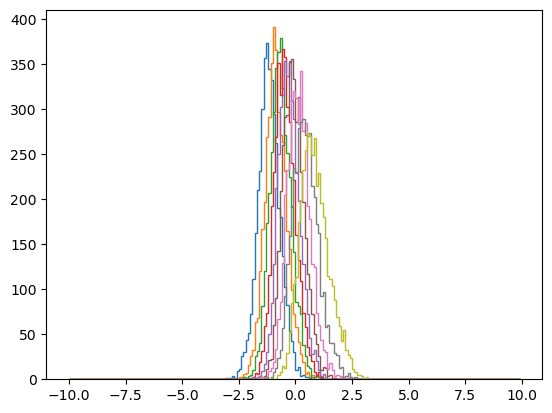

In [8]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

df = pd.DataFrame(columns = ['proportion', 'skew', 'skew statistic', 'skew pvalue',  'kurtosis', 'kurtosis statistic', 'kurtosis pvalue'])

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)
        momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type='fctmoy')

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(scardec_name)

    root_times = np.array(root_times)
    durations = np.array(durations)
    moments = np.log10(np.array(moments))
    relative_root_times = np.array(relative_root_times)

    rel_root_times = relative_root_times/durations

    rel_root_times = scipy.special.logit(rel_root_times)

    skew = stats.skew(rel_root_times, nan_policy='omit')
    kurtosis = stats.kurtosis(rel_root_times, nan_policy='omit')
    kurtosis_test = stats.kurtosistest(rel_root_times, nan_policy='omit')
    skew_test = stats.skewtest(rel_root_times, nan_policy='omit')

    new_data = {'proportion': [proportion], 'skew': [skew], 'skew statistic': [skew_test[0]], 'skew pvalue': [skew_test[1]], 'kurtosis': [kurtosis], 'kurtosis statistic': [kurtosis_test[0]], 'kurtosis pvalue': [kurtosis_test[1]]}
    df = pd.concat([df, pd.DataFrame(new_data)])

    plt.hist(rel_root_times, bins = np.arange(-10, 10, 0.1), histtype='step')

    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/stacked_histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')

In [9]:
skew = stats.skew(rel_root_times)
kurtosis = stats.kurtosis(rel_root_times)
kurtosis_test = stats.kurtosistest(rel_root_times)
skew_test = stats.skewtest(rel_root_times)
print(skew, kurtosis, kurtosis_test, skew_test)

0.44175526998760944 0.028580386781594136 KurtosistestResult(statistic=0.4259722078885244, pvalue=0.6701280975079851) SkewtestResult(statistic=11.055551860629372, pvalue=2.060656024440308e-28)


In [10]:
df

,proportion,skew,skew statistic,skew pvalue,kurtosis,kurtosis statistic,kurtosis pvalue
0,0.1,0.053397,1.395513,1.628613e-01,0.307491,3.558258,0.000373
0,0.2,0.124370,3.240296,1.194059e-03,0.143168,1.807551,0.070676
0,0.3,0.199773,5.174197,2.288928e-07,0.147842,1.860874,0.062762
0,0.4,0.275237,7.069220,1.558072e-12,0.139787,1.768845,0.076920
0,0.5,0.332883,8.482363,2.206654e-17,0.201953,2.462322,0.013804
0,0.6,0.371689,9.414597,4.749009e-21,0.340119,3.878306,0.000105
0,0.7,0.365940,9.277501,1.735002e-20,0.369432,4.158845,0.000032
0,0.8,0.384797,9.725805,2.340466e-22,0.201922,2.461980,0.013817
0,0.9,0.441755,11.055552,2.060656e-28,0.028580,0.425972,0.670128


In [11]:
rel_root_times

array([ 1.62713749,  0.78353124, -0.62168822, ...,  0.23841102,
        1.51982575,  1.07992016])

In [12]:
stats.skew(rel_root_times, nan_policy='omit')

0.44175526998760944